In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, Input
from tensorflow.keras import layers
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint


from tensorflow.keras.layers import LSTM, SimpleRNN, GRU
from tensorflow.keras.layers import Dense, Dropout, concatenate

from pandas import concat
from pandas import read_csv
from helper import series_to_supervised, stage_series_to_supervised

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1, 7"

In [4]:
dataset = pd.read_csv('../../../data/TFT_energy.csv', index_col=0)
dataset.fillna(0, inplace=True)
data = dataset
data

,price,price_dayahead,gen_coal,gen_gas,load_actual,gen_lig,gen_oil,gen_oth_renew,pressure_Barcelona,pressure_Bilbao,...,wind_deg_Bilbao,clouds_all_Bilbao,gen_hyd_river,wind_deg_Seville,wind_speed_Barcelona,wind_speed_Valencia,wind_speed_Bilbao,gen_wind,wind_speed_Madrid,gen_hyd_pump
time,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00+00:00,64.92,48.10,4755.0,5196.0,24382.0,328.0,158.0,71.0,1035.0,1035.0,...,229.0,0.0,1009.0,21.0,7.0,1.0,0.0,5890.0,1.0,920.0
2015-01-01 01:00:00+00:00,64.48,47.33,4581.0,4857.0,22734.0,323.0,157.0,73.0,1036.0,1036.0,...,224.0,0.0,973.0,27.0,7.0,0.0,1.0,5461.0,1.0,1164.0
2015-01-01 02:00:00+00:00,59.32,42.27,4131.0,4314.0,21286.0,254.0,160.0,75.0,1036.0,1035.0,...,225.0,0.0,949.0,27.0,7.0,0.0,1.0,5238.0,1.0,1503.0
2015-01-01 03:00:00+00:00,56.04,38.41,3840.0,4130.0,20264.0,187.0,156.0,74.0,1036.0,1035.0,...,221.0,0.0,953.0,27.0,7.0,0.0,1.0,4935.0,1.0,1826.0
2015-01-01 04:00:00+00:00,53.63,35.72,3590.0,4038.0,19905.0,178.0,156.0,74.0,1037.0,1035.0,...,224.0,0.0,952.0,57.0,5.0,2.0,1.0,4618.0,0.0,2109.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 18:00:00+00:00,77.02,68.85,2628.0,7634.0,30653.0,0.0,178.0,95.0,1027.0,1033.0,...,57.0,0.0,1135.0,30.0,1.0,2.0,0.0,3113.0,1.0,1.0
2018-12-31 19:00:00+00:00,76.16,68.40,2566.0,7241.0,29735.0,0.0,174.0,95.0,1027.0,1034.0,...,0.0,0.0,1172.0,30.0,3.0,1.0,1.0,3288.0,1.0,1.0
2018-12-31 20:00:00+00:00,74.30,66.88,2422.0,7025.0,28071.0,0.0,168.0,94.0,1028.0,1034.0,...,140.0,0.0,1148.0,50.0,4.0,3.0,1.0,3503.0,1.0,50.0


In [5]:
print(dataset.columns)

Index(['price', 'price_dayahead', 'gen_coal', 'gen_gas', 'load_actual',
       'gen_lig', 'gen_oil', 'gen_oth_renew', 'pressure_Barcelona',
       'pressure_Bilbao', 'gen_waste', 'gen_bio', 'temp_min_Valencia',
       'pressure_Valencia', 'temp_min_Barcelona', 'humidity_Seville',
       'wind_deg_Bilbao', 'clouds_all_Bilbao', 'gen_hyd_river',
       'wind_deg_Seville', 'wind_speed_Barcelona', 'wind_speed_Valencia',
       'wind_speed_Bilbao', 'gen_wind', 'wind_speed_Madrid', 'gen_hyd_pump'],
      dtype='object')


In [6]:
# specify the number of lag hours
n_hours = 24*3
K = 24

### Target time series (4)
- 'WS_S1',  'TWS_S25A', 'TWS_S25B', 'TWS_S26',    
        
               
### Prior known covariates (9)
- 'WS_S4', 'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'PUMP_S25B',  'GATE_S26_1', 'GATE_S26_2', 'PUMP_S26', 'MEAN_RAIN'


### Prior unknown covariates (6)
- 'FLOW_S25A', 'HWS_S25A', 'FLOW_S25B', 'HWS_S25B', 'FLOW_S26', 'HWS_S26'

#### Target time series: water stage (4)

In [7]:
# Pre-processing
stages = dataset[['price']]
print("stages.shape:", stages.shape)


stages_supervised = series_to_supervised(stages, n_hours, K)
print("stages_supervised.shape:", stages_supervised.shape)

stages.shape: (35063, 1)
stages_supervised.shape: (34968, 96)


In [8]:
stages_supervised

,var1(t-72),var1(t-71),var1(t-70),var1(t-69),var1(t-68),var1(t-67),var1(t-66),var1(t-65),var1(t-64),var1(t-63),...,var1(t+14),var1(t+15),var1(t+16),var1(t+17),var1(t+18),var1(t+19),var1(t+20),var1(t+21),var1(t+22),var1(t+23)
time,,,,,,,,,,,,,,,,,,,,,
2015-01-04 00:00:00+00:00,64.92,64.48,59.32,56.04,53.63,51.73,51.43,48.98,54.20,58.94,...,52.07,52.15,61.12,71.98,74.64,75.38,76.49,73.83,69.51,70.77
2015-01-04 01:00:00+00:00,64.48,59.32,56.04,53.63,51.73,51.43,48.98,54.20,58.94,59.86,...,52.15,61.12,71.98,74.64,75.38,76.49,73.83,69.51,70.77,64.89
2015-01-04 02:00:00+00:00,59.32,56.04,53.63,51.73,51.43,48.98,54.20,58.94,59.86,60.12,...,61.12,71.98,74.64,75.38,76.49,73.83,69.51,70.77,64.89,60.91
2015-01-04 03:00:00+00:00,56.04,53.63,51.73,51.43,48.98,54.20,58.94,59.86,60.12,62.05,...,71.98,74.64,75.38,76.49,73.83,69.51,70.77,64.89,60.91,59.68
2015-01-04 04:00:00+00:00,53.63,51.73,51.43,48.98,54.20,58.94,59.86,60.12,62.05,62.06,...,74.64,75.38,76.49,73.83,69.51,70.77,64.89,60.91,59.68,58.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-30 19:00:00+00:00,78.99,77.65,73.28,73.48,70.93,68.61,64.19,62.53,59.78,59.82,...,72.12,71.81,72.42,71.80,71.95,70.85,71.36,75.13,77.61,77.02
2018-12-30 20:00:00+00:00,77.65,73.28,73.48,70.93,68.61,64.19,62.53,59.78,59.82,64.27,...,71.81,72.42,71.80,71.95,70.85,71.36,75.13,77.61,77.02,76.16
2018-12-30 21:00:00+00:00,73.28,73.48,70.93,68.61,64.19,62.53,59.78,59.82,64.27,66.81,...,72.42,71.80,71.95,70.85,71.36,75.13,77.61,77.02,76.16,74.30


#### Prior unknown covariates (6)

In [9]:
# prior_unknown = dataset[['FLOW_S25A', 'HWS_S25A', 'FLOW_S25B', 'HWS_S25B', 'FLOW_S26', 'HWS_S26' ]]
# print("prior_unknown.shape:", prior_unknown.shape)

# prior_unknown_supervised = series_to_supervised(prior_unknown, n_hours, K)
# print("prior_unknown_supervised.shape:", prior_unknown_supervised.shape)

In [10]:
# prior_unknown_supervised

#### Prior known covariates (9)

In [11]:
prior_known = dataset[['price_dayahead', 'gen_coal', 'gen_gas', 'load_actual',
       'gen_lig', 'gen_oil', 'gen_oth_renew', 'pressure_Barcelona',
       'pressure_Bilbao', 'gen_waste', 'gen_bio', 'temp_min_Valencia',
       'pressure_Valencia', 'temp_min_Barcelona', 'humidity_Seville',
       'wind_deg_Bilbao', 'clouds_all_Bilbao', 'gen_hyd_river',
       'wind_deg_Seville', 'wind_speed_Barcelona', 'wind_speed_Valencia',
       'wind_speed_Bilbao', 'gen_wind', 'wind_speed_Madrid', 'gen_hyd_pump']]
print("prior_known.shape:", prior_known.shape)

prior_known_supervised = series_to_supervised(prior_known, n_hours, K)
print("prior_known_supervised.shape:", prior_known_supervised.shape)

prior_known.shape: (35063, 25)
prior_known_supervised.shape: (34968, 2400)


In [12]:
# prior_known_supervised

### N_out, N_in, K

In [13]:
past_cov = dataset[['price_dayahead', 'gen_coal', 'gen_gas', 'load_actual',
       'gen_lig', 'gen_oil', 'gen_oth_renew', 'pressure_Barcelona',
       'pressure_Bilbao', 'gen_waste', 'gen_bio', 'temp_min_Valencia',
       'pressure_Valencia', 'temp_min_Barcelona', 'humidity_Seville',
       'wind_deg_Bilbao', 'clouds_all_Bilbao', 'gen_hyd_river',
       'wind_deg_Seville', 'wind_speed_Barcelona', 'wind_speed_Valencia',
       'wind_speed_Bilbao', 'gen_wind', 'wind_speed_Madrid', 'gen_hyd_pump']]

past_cov_supervised = series_to_supervised(past_cov, n_hours, K)
print("past_cov_supervised.shape:", past_cov_supervised.shape)

past_cov_supervised.shape: (34968, 2400)


In [14]:
# past_cov_supervised  # 6 + 9 = 15 features

In [15]:
past_ws_supervised = stages_supervised.iloc[:, :n_hours*stages.shape[1]]
past_ws_supervised.reset_index(drop=True, inplace=True)
past_ws_supervised.columns = ['past_ws_supervised_' + i for i in list(past_ws_supervised.columns)]

In [16]:
# past_ws_supervised  # 4

In [17]:
columns = []
for i in range(n_hours):
    columns = columns + past_cov_supervised.columns[i*past_cov.shape[1]:(i+1)*past_cov.shape[1]].tolist()
    columns = columns + past_ws_supervised.columns[i*stages.shape[1]:(i+1)*stages.shape[1]].tolist()
# columns

In [18]:
past_cov_supervised.reset_index(drop=True, inplace=True)
past_ws_supervised.reset_index(drop=True, inplace=True)

past_cov_ws_supervised = pd.concat([past_cov_supervised, past_ws_supervised], axis=1)
past_cov_ws_supervised = past_cov_ws_supervised[columns]


In [19]:
# past_cov_ws_supervised

In [20]:
shift_prior_known_supervised = prior_known_supervised.iloc[:, K*prior_known.shape[1]:]  # shift 2 days for prior known covariates
shift_prior_known_supervised.reset_index(drop=True, inplace=True)
shift_prior_known_supervised.columns = ['shift_prior_known_supervised_' + i for i in list(shift_prior_known_supervised.columns)]
shift_prior_known_supervised

,shift_prior_known_supervised_var1(t-48),shift_prior_known_supervised_var2(t-48),shift_prior_known_supervised_var3(t-48),shift_prior_known_supervised_var4(t-48),shift_prior_known_supervised_var5(t-48),shift_prior_known_supervised_var6(t-48),shift_prior_known_supervised_var7(t-48),shift_prior_known_supervised_var8(t-48),shift_prior_known_supervised_var9(t-48),shift_prior_known_supervised_var10(t-48),...,shift_prior_known_supervised_var16(t+23),shift_prior_known_supervised_var17(t+23),shift_prior_known_supervised_var18(t+23),shift_prior_known_supervised_var19(t+23),shift_prior_known_supervised_var20(t+23),shift_prior_known_supervised_var21(t+23),shift_prior_known_supervised_var22(t+23),shift_prior_known_supervised_var23(t+23),shift_prior_known_supervised_var24(t+23),shift_prior_known_supervised_var25(t+23)
0,7.00,1190.0,2902.0,24935.0,0.0,192.0,61.0,1038.0,1036.0,167.0,...,156.0,21.0,1182.0,132.0,2.0,1.0,0.0,7351.0,1.0,650.0
1,5.00,1023.0,2772.0,23214.0,0.0,189.0,60.0,1037.0,1036.0,167.0,...,163.0,12.0,1099.0,132.0,1.0,1.0,0.0,7403.0,1.0,938.0
2,4.00,1016.0,2936.0,22540.0,0.0,188.0,59.0,1037.0,1036.0,181.0,...,160.0,13.0,1076.0,108.0,2.0,2.0,0.0,7887.0,1.0,1021.0
3,4.00,1103.0,2893.0,22096.0,0.0,189.0,61.0,1037.0,1037.0,181.0,...,165.0,6.0,982.0,108.0,1.0,2.0,0.0,8348.0,1.0,2067.0
4,4.80,1120.0,2889.0,22066.0,0.0,190.0,59.0,1038.0,1037.0,171.0,...,162.0,20.0,982.0,108.0,1.0,2.0,0.0,8348.0,1.0,2067.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34963,66.00,2931.0,9149.0,32642.0,718.0,294.0,103.0,1028.0,1033.0,314.0,...,57.0,0.0,1135.0,30.0,1.0,2.0,0.0,3113.0,1.0,1.0
34964,62.09,2889.0,8024.0,32155.0,675.0,294.0,103.0,1028.0,1033.0,315.0,...,0.0,0.0,1172.0,30.0,3.0,1.0,1.0,3288.0,1.0,1.0
34965,61.77,2871.0,6871.0,30428.0,569.0,291.0,104.0,1029.0,1033.0,314.0,...,140.0,0.0,1148.0,50.0,4.0,3.0,1.0,3503.0,1.0,50.0
34966,58.43,2619.0,5822.0,28015.0,310.0,288.0,103.0,1029.0,1033.0,313.0,...,120.0,0.0,1128.0,60.0,5.0,2.0,1.0,3586.0,2.0,108.0


In [21]:
shift_prior_known_past_cov_ws_supervised = pd.concat([past_cov_ws_supervised, shift_prior_known_supervised], 
                                                     axis=1)


In [22]:
# shift_prior_known_past_cov_ws_supervised

In [23]:
future_ws_supervised = stages_supervised.iloc[:, n_hours*stages.shape[1]:]
future_ws_supervised.reset_index(drop=True, inplace=True)
future_ws_supervised

,var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6),var1(t+7),var1(t+8),var1(t+9),...,var1(t+14),var1(t+15),var1(t+16),var1(t+17),var1(t+18),var1(t+19),var1(t+20),var1(t+21),var1(t+22),var1(t+23)
0,50.54,48.68,48.02,47.06,46.79,47.63,47.44,50.84,54.84,59.95,...,52.07,52.15,61.12,71.98,74.64,75.38,76.49,73.83,69.51,70.77
1,48.68,48.02,47.06,46.79,47.63,47.44,50.84,54.84,59.95,59.35,...,52.15,61.12,71.98,74.64,75.38,76.49,73.83,69.51,70.77,64.89
2,48.02,47.06,46.79,47.63,47.44,50.84,54.84,59.95,59.35,57.03,...,61.12,71.98,74.64,75.38,76.49,73.83,69.51,70.77,64.89,60.91
3,47.06,46.79,47.63,47.44,50.84,54.84,59.95,59.35,57.03,59.22,...,71.98,74.64,75.38,76.49,73.83,69.51,70.77,64.89,60.91,59.68
4,46.79,47.63,47.44,50.84,54.84,59.95,59.35,57.03,59.22,58.56,...,74.64,75.38,76.49,73.83,69.51,70.77,64.89,60.91,59.68,58.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34963,73.35,73.64,71.92,69.49,68.40,60.32,57.73,57.66,57.04,57.48,...,72.12,71.81,72.42,71.80,71.95,70.85,71.36,75.13,77.61,77.02
34964,73.64,71.92,69.49,68.40,60.32,57.73,57.66,57.04,57.48,61.13,...,71.81,72.42,71.80,71.95,70.85,71.36,75.13,77.61,77.02,76.16
34965,71.92,69.49,68.40,60.32,57.73,57.66,57.04,57.48,61.13,60.70,...,72.42,71.80,71.95,70.85,71.36,75.13,77.61,77.02,76.16,74.30
34966,69.49,68.40,60.32,57.73,57.66,57.04,57.48,61.13,60.70,66.64,...,71.80,71.95,70.85,71.36,75.13,77.61,77.02,76.16,74.30,69.89


### Concatenation

In [24]:
all_data = concat([shift_prior_known_past_cov_ws_supervised, future_ws_supervised], axis=1)
# print("all_data", all_data)
print("all_data.shape:", all_data.shape)

all_data.shape: (34968, 3696)


### Train & Test set

In [25]:
all_data = all_data.values
n_train_hours = int(len(all_data)*0.8)
print("n_train_hours:", n_train_hours)


train = all_data[:n_train_hours, :]
test = all_data[n_train_hours:, :]

n_train_hours: 27974


In [26]:
n_obs = n_hours * (prior_known.shape[1]+data.shape[1])
n_obs

3672

### Normalization

In [27]:
# split into input and outputs
all_features = prior_known.shape[1] + data.shape[1]
n_obs = n_hours * all_features
train_X, train_y = train[:, :n_obs], train[:, n_obs:]
test_X, test_y = test[:, :n_obs], test[:, n_obs:]
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape", train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
train_X = scaler.fit_transform(train_X)
train_y = scaler.fit_transform(train_y)
test_X = scaler.fit_transform(test_X)
test_y = scaler.fit_transform(test_y)

train_X.shape, train_y.shape, test_X.shape, test_y.shape (27974, 3672) (27974, 24) (6994, 3672) (6994, 24)


In [28]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, all_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, all_features))
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape: \n", train_X.shape, train_y.shape, test_X.shape, test_y.shape)

train_X.shape, train_y.shape, test_X.shape, test_y.shape: 
 (27974, 72, 51) (27974, 24) (6994, 72, 51) (6994, 24)


### Model

In [30]:
model_input = Input(shape=(train_X.shape[1], train_X.shape[2]))
x = layers.SimpleRNN(128, 
                     activation='relu', 
                     kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5),
                     recurrent_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5),
                     return_sequences=True)(model_input)
x = layers.SimpleRNN(64, 
                     activation='relu', 
                     kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5),
                     recurrent_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5),
                     return_sequences=True)(x)
x = layers.SimpleRNN(32, 
                     activation='relu', 
                     kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5),
                     recurrent_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5),
                     return_sequences=True)(x)
x = layers.SimpleRNN(16, 
                     activation='relu', 
                     kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5),
                     recurrent_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5),
                     return_sequences=True)(x)
x = layers.Flatten()(x)
x = Dense(256, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x)
x = Dense(128, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x)
x = Dense(64, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x)

output = layers.Dense(train_y.shape[1])(x)

model_rnn = Model(model_input, output)
model_rnn.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 72, 51)]          0         
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 72, 128)           23040     
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 72, 64)            12352     
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 72, 32)            3104      
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, 72, 16)            784       
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               2951

Epoch 1/6000


2023-02-07 10:58:38.071454: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10



Epoch 00001: val_mae improved from inf to 0.20052, saving model to saved_model/rnn_shift_anyday_24h_4layer_no_sc.h5
55/55 - 10s - loss: 0.1893 - mae: 0.1381 - val_loss: 0.1833 - val_mae: 0.2005
Epoch 2/6000

Epoch 00002: val_mae improved from 0.20052 to 0.17407, saving model to saved_model/rnn_shift_anyday_24h_4layer_no_sc.h5
55/55 - 9s - loss: 0.1296 - mae: 0.0788 - val_loss: 0.1444 - val_mae: 0.1741
Epoch 3/6000

Epoch 00003: val_mae improved from 0.17407 to 0.12411, saving model to saved_model/rnn_shift_anyday_24h_4layer_no_sc.h5
55/55 - 9s - loss: 0.1071 - mae: 0.0722 - val_loss: 0.1125 - val_mae: 0.1241
Epoch 4/6000

Epoch 00004: val_mae improved from 0.12411 to 0.12031, saving model to saved_model/rnn_shift_anyday_24h_4layer_no_sc.h5
55/55 - 9s - loss: 0.0937 - mae: 0.0656 - val_loss: 0.1011 - val_mae: 0.1203
Epoch 5/6000

Epoch 00005: val_mae improved from 0.12031 to 0.09329, saving model to saved_model/rnn_shift_anyday_24h_4layer_no_sc.h5
55/55 - 9s - loss: 0.0838 - mae: 0.060

Epoch 51/6000

Epoch 00051: val_mae did not improve from 0.05149
55/55 - 9s - loss: 0.0165 - mae: 0.0431 - val_loss: 0.0182 - val_mae: 0.0549
Epoch 52/6000

Epoch 00052: val_mae improved from 0.05149 to 0.05055, saving model to saved_model/rnn_shift_anyday_24h_4layer_no_sc.h5
55/55 - 9s - loss: 0.0163 - mae: 0.0431 - val_loss: 0.0173 - val_mae: 0.0505
Epoch 53/6000

Epoch 00053: val_mae did not improve from 0.05055
55/55 - 9s - loss: 0.0162 - mae: 0.0444 - val_loss: 0.0184 - val_mae: 0.0593
Epoch 54/6000

Epoch 00054: val_mae did not improve from 0.05055
55/55 - 9s - loss: 0.0158 - mae: 0.0430 - val_loss: 0.0176 - val_mae: 0.0555
Epoch 55/6000

Epoch 00055: val_mae did not improve from 0.05055
55/55 - 9s - loss: 0.0156 - mae: 0.0428 - val_loss: 0.0177 - val_mae: 0.0581
Epoch 56/6000

Epoch 00056: val_mae did not improve from 0.05055
55/55 - 9s - loss: 0.0154 - mae: 0.0430 - val_loss: 0.0177 - val_mae: 0.0595
Epoch 57/6000

Epoch 00057: val_mae did not improve from 0.05055
55/55 - 9s - 

Epoch 108/6000

Epoch 00108: val_mae did not improve from 0.05040
55/55 - 9s - loss: 0.0096 - mae: 0.0415 - val_loss: 0.0121 - val_mae: 0.0589
Epoch 109/6000

Epoch 00109: val_mae did not improve from 0.05040
55/55 - 10s - loss: 0.0095 - mae: 0.0414 - val_loss: 0.0148 - val_mae: 0.0765
Epoch 110/6000

Epoch 00110: val_mae did not improve from 0.05040
55/55 - 9s - loss: 0.0095 - mae: 0.0417 - val_loss: 0.0126 - val_mae: 0.0632
Epoch 111/6000

Epoch 00111: val_mae did not improve from 0.05040
55/55 - 9s - loss: 0.0095 - mae: 0.0419 - val_loss: 0.0109 - val_mae: 0.0521
Epoch 112/6000

Epoch 00112: val_mae did not improve from 0.05040
55/55 - 9s - loss: 0.0094 - mae: 0.0419 - val_loss: 0.0120 - val_mae: 0.0598
Epoch 113/6000

Epoch 00113: val_mae did not improve from 0.05040
55/55 - 9s - loss: 0.0093 - mae: 0.0418 - val_loss: 0.0134 - val_mae: 0.0694
Epoch 114/6000

Epoch 00114: val_mae did not improve from 0.05040
55/55 - 9s - loss: 0.0093 - mae: 0.0419 - val_loss: 0.0125 - val_mae: 0.064

Epoch 165/6000

Epoch 00165: val_mae did not improve from 0.04891
55/55 - 10s - loss: 0.0072 - mae: 0.0405 - val_loss: 0.0103 - val_mae: 0.0626
Epoch 166/6000

Epoch 00166: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0071 - mae: 0.0402 - val_loss: 0.0091 - val_mae: 0.0544
Epoch 167/6000

Epoch 00167: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0072 - mae: 0.0407 - val_loss: 0.0101 - val_mae: 0.0615
Epoch 168/6000

Epoch 00168: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0072 - mae: 0.0409 - val_loss: 0.0097 - val_mae: 0.0594
Epoch 169/6000

Epoch 00169: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0071 - mae: 0.0402 - val_loss: 0.0091 - val_mae: 0.0547
Epoch 170/6000

Epoch 00170: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0071 - mae: 0.0406 - val_loss: 0.0105 - val_mae: 0.0644
Epoch 171/6000

Epoch 00171: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0071 - mae: 0.0405 - val_loss: 0.0111 - val_mae: 0.068

Epoch 223/6000

Epoch 00223: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0061 - mae: 0.0394 - val_loss: 0.0087 - val_mae: 0.0580
Epoch 224/6000

Epoch 00224: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0061 - mae: 0.0394 - val_loss: 0.0096 - val_mae: 0.0648
Epoch 225/6000

Epoch 00225: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0061 - mae: 0.0398 - val_loss: 0.0085 - val_mae: 0.0570
Epoch 226/6000

Epoch 00226: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0061 - mae: 0.0398 - val_loss: 0.0090 - val_mae: 0.0610
Epoch 227/6000

Epoch 00227: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0061 - mae: 0.0397 - val_loss: 0.0108 - val_mae: 0.0716
Epoch 228/6000

Epoch 00228: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0061 - mae: 0.0402 - val_loss: 0.0093 - val_mae: 0.0626
Epoch 229/6000

Epoch 00229: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0060 - mae: 0.0397 - val_loss: 0.0081 - val_mae: 0.0548

Epoch 281/6000

Epoch 00281: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0056 - mae: 0.0394 - val_loss: 0.0082 - val_mae: 0.0584
Epoch 282/6000

Epoch 00282: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0055 - mae: 0.0391 - val_loss: 0.0086 - val_mae: 0.0609
Epoch 283/6000

Epoch 00283: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0055 - mae: 0.0392 - val_loss: 0.0084 - val_mae: 0.0594
Epoch 284/6000

Epoch 00284: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0055 - mae: 0.0391 - val_loss: 0.0113 - val_mae: 0.0776
Epoch 285/6000

Epoch 00285: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0055 - mae: 0.0389 - val_loss: 0.0096 - val_mae: 0.0674
Epoch 286/6000

Epoch 00286: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0055 - mae: 0.0390 - val_loss: 0.0095 - val_mae: 0.0673
Epoch 287/6000

Epoch 00287: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0055 - mae: 0.0393 - val_loss: 0.0099 - val_mae: 0.0691

Epoch 339/6000

Epoch 00339: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0051 - mae: 0.0386 - val_loss: 0.0081 - val_mae: 0.0595
Epoch 340/6000

Epoch 00340: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0051 - mae: 0.0385 - val_loss: 0.0079 - val_mae: 0.0578
Epoch 341/6000

Epoch 00341: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0051 - mae: 0.0387 - val_loss: 0.0084 - val_mae: 0.0615
Epoch 342/6000

Epoch 00342: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0051 - mae: 0.0385 - val_loss: 0.0087 - val_mae: 0.0631
Epoch 343/6000

Epoch 00343: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0051 - mae: 0.0385 - val_loss: 0.0084 - val_mae: 0.0614
Epoch 344/6000

Epoch 00344: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0051 - mae: 0.0385 - val_loss: 0.0084 - val_mae: 0.0616
Epoch 345/6000

Epoch 00345: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0051 - mae: 0.0384 - val_loss: 0.0084 - val_mae: 0.0615

Epoch 397/6000

Epoch 00397: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0049 - mae: 0.0385 - val_loss: 0.0073 - val_mae: 0.0555
Epoch 398/6000

Epoch 00398: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0049 - mae: 0.0385 - val_loss: 0.0084 - val_mae: 0.0629
Epoch 399/6000

Epoch 00399: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0049 - mae: 0.0383 - val_loss: 0.0077 - val_mae: 0.0582
Epoch 400/6000

Epoch 00400: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0049 - mae: 0.0381 - val_loss: 0.0087 - val_mae: 0.0650
Epoch 401/6000

Epoch 00401: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0049 - mae: 0.0385 - val_loss: 0.0081 - val_mae: 0.0610
Epoch 402/6000

Epoch 00402: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0049 - mae: 0.0383 - val_loss: 0.0092 - val_mae: 0.0677
Epoch 403/6000

Epoch 00403: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0049 - mae: 0.0383 - val_loss: 0.0078 - val_mae: 0.0588

Epoch 455/6000

Epoch 00455: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0047 - mae: 0.0381 - val_loss: 0.0075 - val_mae: 0.0578
Epoch 456/6000

Epoch 00456: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0047 - mae: 0.0379 - val_loss: 0.0077 - val_mae: 0.0586
Epoch 457/6000

Epoch 00457: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0047 - mae: 0.0379 - val_loss: 0.0087 - val_mae: 0.0651
Epoch 458/6000

Epoch 00458: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0048 - mae: 0.0386 - val_loss: 0.0080 - val_mae: 0.0613
Epoch 459/6000

Epoch 00459: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0047 - mae: 0.0383 - val_loss: 0.0072 - val_mae: 0.0557
Epoch 460/6000

Epoch 00460: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0047 - mae: 0.0381 - val_loss: 0.0073 - val_mae: 0.0564
Epoch 461/6000

Epoch 00461: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0047 - mae: 0.0379 - val_loss: 0.0088 - val_mae: 0.0664

Epoch 513/6000

Epoch 00513: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0046 - mae: 0.0379 - val_loss: 0.0077 - val_mae: 0.0594
Epoch 514/6000

Epoch 00514: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0046 - mae: 0.0380 - val_loss: 0.0079 - val_mae: 0.0610
Epoch 515/6000

Epoch 00515: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0045 - mae: 0.0376 - val_loss: 0.0083 - val_mae: 0.0636
Epoch 516/6000

Epoch 00516: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0046 - mae: 0.0379 - val_loss: 0.0086 - val_mae: 0.0655
Epoch 517/6000

Epoch 00517: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0045 - mae: 0.0376 - val_loss: 0.0082 - val_mae: 0.0625
Epoch 518/6000

Epoch 00518: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0045 - mae: 0.0377 - val_loss: 0.0081 - val_mae: 0.0622
Epoch 519/6000

Epoch 00519: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0046 - mae: 0.0384 - val_loss: 0.0099 - val_mae: 0.0725

Epoch 571/6000

Epoch 00571: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0045 - mae: 0.0376 - val_loss: 0.0090 - val_mae: 0.0684
Epoch 572/6000

Epoch 00572: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0045 - mae: 0.0377 - val_loss: 0.0086 - val_mae: 0.0657
Epoch 573/6000

Epoch 00573: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0045 - mae: 0.0379 - val_loss: 0.0080 - val_mae: 0.0620
Epoch 574/6000

Epoch 00574: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0045 - mae: 0.0376 - val_loss: 0.0089 - val_mae: 0.0676
Epoch 575/6000

Epoch 00575: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0045 - mae: 0.0376 - val_loss: 0.0093 - val_mae: 0.0697
Epoch 576/6000

Epoch 00576: val_mae did not improve from 0.04891
55/55 - 10s - loss: 0.0045 - mae: 0.0377 - val_loss: 0.0093 - val_mae: 0.0693
Epoch 577/6000

Epoch 00577: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0045 - mae: 0.0377 - val_loss: 0.0076 - val_mae: 0.059

Epoch 629/6000

Epoch 00629: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0044 - mae: 0.0373 - val_loss: 0.0082 - val_mae: 0.0637
Epoch 630/6000

Epoch 00630: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0044 - mae: 0.0373 - val_loss: 0.0084 - val_mae: 0.0649
Epoch 631/6000

Epoch 00631: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0044 - mae: 0.0378 - val_loss: 0.0084 - val_mae: 0.0643
Epoch 632/6000

Epoch 00632: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0044 - mae: 0.0375 - val_loss: 0.0075 - val_mae: 0.0592
Epoch 633/6000

Epoch 00633: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0044 - mae: 0.0375 - val_loss: 0.0085 - val_mae: 0.0651
Epoch 634/6000

Epoch 00634: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0044 - mae: 0.0373 - val_loss: 0.0084 - val_mae: 0.0648
Epoch 635/6000

Epoch 00635: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0044 - mae: 0.0373 - val_loss: 0.0082 - val_mae: 0.0634

Epoch 687/6000

Epoch 00687: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0043 - mae: 0.0373 - val_loss: 0.0082 - val_mae: 0.0635
Epoch 688/6000

Epoch 00688: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0043 - mae: 0.0371 - val_loss: 0.0082 - val_mae: 0.0632
Epoch 689/6000

Epoch 00689: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0043 - mae: 0.0372 - val_loss: 0.0084 - val_mae: 0.0647
Epoch 690/6000

Epoch 00690: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0043 - mae: 0.0373 - val_loss: 0.0076 - val_mae: 0.0600
Epoch 691/6000

Epoch 00691: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0043 - mae: 0.0371 - val_loss: 0.0086 - val_mae: 0.0661
Epoch 692/6000

Epoch 00692: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0043 - mae: 0.0372 - val_loss: 0.0073 - val_mae: 0.0579
Epoch 693/6000

Epoch 00693: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0043 - mae: 0.0375 - val_loss: 0.0091 - val_mae: 0.0691

Epoch 745/6000

Epoch 00745: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0043 - mae: 0.0371 - val_loss: 0.0078 - val_mae: 0.0612
Epoch 746/6000

Epoch 00746: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0043 - mae: 0.0374 - val_loss: 0.0079 - val_mae: 0.0621
Epoch 747/6000

Epoch 00747: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0043 - mae: 0.0372 - val_loss: 0.0076 - val_mae: 0.0599
Epoch 748/6000

Epoch 00748: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0043 - mae: 0.0373 - val_loss: 0.0080 - val_mae: 0.0621
Epoch 749/6000

Epoch 00749: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0043 - mae: 0.0375 - val_loss: 0.0080 - val_mae: 0.0623
Epoch 750/6000

Epoch 00750: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0043 - mae: 0.0373 - val_loss: 0.0081 - val_mae: 0.0632
Epoch 751/6000

Epoch 00751: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0043 - mae: 0.0371 - val_loss: 0.0075 - val_mae: 0.0591

Epoch 803/6000

Epoch 00803: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0042 - mae: 0.0370 - val_loss: 0.0082 - val_mae: 0.0637
Epoch 804/6000

Epoch 00804: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0042 - mae: 0.0372 - val_loss: 0.0080 - val_mae: 0.0629
Epoch 805/6000

Epoch 00805: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0042 - mae: 0.0369 - val_loss: 0.0081 - val_mae: 0.0635
Epoch 806/6000

Epoch 00806: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0042 - mae: 0.0369 - val_loss: 0.0084 - val_mae: 0.0648
Epoch 807/6000

Epoch 00807: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0042 - mae: 0.0370 - val_loss: 0.0079 - val_mae: 0.0619
Epoch 808/6000

Epoch 00808: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0042 - mae: 0.0369 - val_loss: 0.0081 - val_mae: 0.0632
Epoch 809/6000

Epoch 00809: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0042 - mae: 0.0369 - val_loss: 0.0081 - val_mae: 0.0636

Epoch 861/6000

Epoch 00861: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0042 - mae: 0.0373 - val_loss: 0.0087 - val_mae: 0.0664
Epoch 862/6000

Epoch 00862: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0042 - mae: 0.0369 - val_loss: 0.0077 - val_mae: 0.0612
Epoch 863/6000

Epoch 00863: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0042 - mae: 0.0374 - val_loss: 0.0094 - val_mae: 0.0707
Epoch 864/6000

Epoch 00864: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0042 - mae: 0.0371 - val_loss: 0.0085 - val_mae: 0.0658
Epoch 865/6000

Epoch 00865: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0042 - mae: 0.0368 - val_loss: 0.0073 - val_mae: 0.0587
Epoch 866/6000

Epoch 00866: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0042 - mae: 0.0371 - val_loss: 0.0081 - val_mae: 0.0640
Epoch 867/6000

Epoch 00867: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0042 - mae: 0.0370 - val_loss: 0.0076 - val_mae: 0.0605

Epoch 919/6000

Epoch 00919: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0041 - mae: 0.0368 - val_loss: 0.0076 - val_mae: 0.0603
Epoch 920/6000

Epoch 00920: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0041 - mae: 0.0368 - val_loss: 0.0073 - val_mae: 0.0591
Epoch 921/6000

Epoch 00921: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0041 - mae: 0.0367 - val_loss: 0.0087 - val_mae: 0.0674
Epoch 922/6000

Epoch 00922: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0041 - mae: 0.0369 - val_loss: 0.0085 - val_mae: 0.0659
Epoch 923/6000

Epoch 00923: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0041 - mae: 0.0369 - val_loss: 0.0087 - val_mae: 0.0669
Epoch 924/6000

Epoch 00924: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0041 - mae: 0.0371 - val_loss: 0.0077 - val_mae: 0.0614
Epoch 925/6000

Epoch 00925: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0041 - mae: 0.0370 - val_loss: 0.0098 - val_mae: 0.0735

Epoch 977/6000

Epoch 00977: val_mae did not improve from 0.04891
55/55 - 10s - loss: 0.0041 - mae: 0.0368 - val_loss: 0.0079 - val_mae: 0.0627
Epoch 978/6000

Epoch 00978: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0041 - mae: 0.0366 - val_loss: 0.0076 - val_mae: 0.0606
Epoch 979/6000

Epoch 00979: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0041 - mae: 0.0368 - val_loss: 0.0075 - val_mae: 0.0605
Epoch 980/6000

Epoch 00980: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0041 - mae: 0.0368 - val_loss: 0.0080 - val_mae: 0.0629
Epoch 981/6000

Epoch 00981: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0041 - mae: 0.0368 - val_loss: 0.0082 - val_mae: 0.0644
Epoch 982/6000

Epoch 00982: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0041 - mae: 0.0369 - val_loss: 0.0083 - val_mae: 0.0650
Epoch 983/6000

Epoch 00983: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0041 - mae: 0.0366 - val_loss: 0.0075 - val_mae: 0.060


Epoch 01034: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0040 - mae: 0.0367 - val_loss: 0.0079 - val_mae: 0.0621
Epoch 1035/6000

Epoch 01035: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0041 - mae: 0.0368 - val_loss: 0.0078 - val_mae: 0.0619
Epoch 1036/6000

Epoch 01036: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0040 - mae: 0.0366 - val_loss: 0.0075 - val_mae: 0.0607
Epoch 1037/6000

Epoch 01037: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0040 - mae: 0.0365 - val_loss: 0.0081 - val_mae: 0.0637
Epoch 1038/6000

Epoch 01038: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0040 - mae: 0.0367 - val_loss: 0.0076 - val_mae: 0.0611
Epoch 1039/6000

Epoch 01039: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0040 - mae: 0.0367 - val_loss: 0.0076 - val_mae: 0.0613
Epoch 1040/6000

Epoch 01040: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0040 - mae: 0.0367 - val_loss: 0.0079 - val_mae: 0.0624
Epoch 10

Epoch 1091/6000

Epoch 01091: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0040 - mae: 0.0366 - val_loss: 0.0077 - val_mae: 0.0619
Epoch 1092/6000

Epoch 01092: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0040 - mae: 0.0365 - val_loss: 0.0084 - val_mae: 0.0660
Epoch 1093/6000

Epoch 01093: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0040 - mae: 0.0367 - val_loss: 0.0083 - val_mae: 0.0654
Epoch 1094/6000

Epoch 01094: val_mae did not improve from 0.04891
55/55 - 10s - loss: 0.0040 - mae: 0.0365 - val_loss: 0.0077 - val_mae: 0.0614
Epoch 1095/6000

Epoch 01095: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0040 - mae: 0.0364 - val_loss: 0.0078 - val_mae: 0.0624
Epoch 1096/6000

Epoch 01096: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0040 - mae: 0.0366 - val_loss: 0.0085 - val_mae: 0.0669
Epoch 1097/6000

Epoch 01097: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0040 - mae: 0.0364 - val_loss: 0.0077 - val_mae

Epoch 1148/6000

Epoch 01148: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0039 - mae: 0.0364 - val_loss: 0.0078 - val_mae: 0.0625
Epoch 1149/6000

Epoch 01149: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0040 - mae: 0.0367 - val_loss: 0.0076 - val_mae: 0.0608
Epoch 1150/6000

Epoch 01150: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0040 - mae: 0.0365 - val_loss: 0.0072 - val_mae: 0.0592
Epoch 1151/6000

Epoch 01151: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0040 - mae: 0.0370 - val_loss: 0.0077 - val_mae: 0.0622
Epoch 1152/6000

Epoch 01152: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0039 - mae: 0.0365 - val_loss: 0.0080 - val_mae: 0.0634
Epoch 1153/6000

Epoch 01153: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0040 - mae: 0.0366 - val_loss: 0.0074 - val_mae: 0.0600
Epoch 1154/6000

Epoch 01154: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0040 - mae: 0.0371 - val_loss: 0.0075 - val_mae:

Epoch 1205/6000

Epoch 01205: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0040 - mae: 0.0370 - val_loss: 0.0081 - val_mae: 0.0647
Epoch 1206/6000

Epoch 01206: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0039 - mae: 0.0364 - val_loss: 0.0090 - val_mae: 0.0696
Epoch 1207/6000

Epoch 01207: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0039 - mae: 0.0365 - val_loss: 0.0076 - val_mae: 0.0614
Epoch 1208/6000

Epoch 01208: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0039 - mae: 0.0364 - val_loss: 0.0083 - val_mae: 0.0658
Epoch 1209/6000

Epoch 01209: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0039 - mae: 0.0365 - val_loss: 0.0082 - val_mae: 0.0653
Epoch 1210/6000

Epoch 01210: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0039 - mae: 0.0364 - val_loss: 0.0076 - val_mae: 0.0616
Epoch 1211/6000

Epoch 01211: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0039 - mae: 0.0365 - val_loss: 0.0080 - val_mae:

Epoch 1262/6000

Epoch 01262: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0039 - mae: 0.0366 - val_loss: 0.0083 - val_mae: 0.0660
Epoch 1263/6000

Epoch 01263: val_mae did not improve from 0.04891
55/55 - 8s - loss: 0.0039 - mae: 0.0366 - val_loss: 0.0077 - val_mae: 0.0623
Epoch 1264/6000

Epoch 01264: val_mae did not improve from 0.04891
55/55 - 8s - loss: 0.0039 - mae: 0.0364 - val_loss: 0.0072 - val_mae: 0.0590
Epoch 1265/6000

Epoch 01265: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0039 - mae: 0.0366 - val_loss: 0.0075 - val_mae: 0.0612
Epoch 1266/6000

Epoch 01266: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0039 - mae: 0.0363 - val_loss: 0.0078 - val_mae: 0.0629
Epoch 1267/6000

Epoch 01267: val_mae did not improve from 0.04891
55/55 - 8s - loss: 0.0039 - mae: 0.0364 - val_loss: 0.0077 - val_mae: 0.0621
Epoch 1268/6000

Epoch 01268: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0039 - mae: 0.0365 - val_loss: 0.0080 - val_mae:

Epoch 1326/6000

Epoch 01326: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0038 - mae: 0.0365 - val_loss: 0.0081 - val_mae: 0.0650
Epoch 1327/6000

Epoch 01327: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0038 - mae: 0.0365 - val_loss: 0.0074 - val_mae: 0.0603
Epoch 1328/6000

Epoch 01328: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0038 - mae: 0.0364 - val_loss: 0.0080 - val_mae: 0.0644
Epoch 1329/6000

Epoch 01329: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0038 - mae: 0.0363 - val_loss: 0.0080 - val_mae: 0.0640
Epoch 1330/6000

Epoch 01330: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0038 - mae: 0.0362 - val_loss: 0.0078 - val_mae: 0.0629
Epoch 1331/6000

Epoch 01331: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0038 - mae: 0.0364 - val_loss: 0.0074 - val_mae: 0.0605
Epoch 1332/6000

Epoch 01332: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0038 - mae: 0.0363 - val_loss: 0.0080 - val_mae:

Epoch 1383/6000

Epoch 01383: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0038 - mae: 0.0363 - val_loss: 0.0074 - val_mae: 0.0608
Epoch 1384/6000

Epoch 01384: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0038 - mae: 0.0361 - val_loss: 0.0077 - val_mae: 0.0624
Epoch 1385/6000

Epoch 01385: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0038 - mae: 0.0361 - val_loss: 0.0074 - val_mae: 0.0609
Epoch 1386/6000

Epoch 01386: val_mae did not improve from 0.04891
55/55 - 8s - loss: 0.0038 - mae: 0.0362 - val_loss: 0.0075 - val_mae: 0.0611
Epoch 1387/6000

Epoch 01387: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0038 - mae: 0.0365 - val_loss: 0.0073 - val_mae: 0.0601
Epoch 1388/6000

Epoch 01388: val_mae did not improve from 0.04891
55/55 - 8s - loss: 0.0038 - mae: 0.0364 - val_loss: 0.0077 - val_mae: 0.0622
Epoch 1389/6000

Epoch 01389: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0038 - mae: 0.0363 - val_loss: 0.0076 - val_mae:

Epoch 1440/6000

Epoch 01440: val_mae did not improve from 0.04891
55/55 - 9s - loss: 0.0037 - mae: 0.0361 - val_loss: 0.0080 - val_mae: 0.0646
Epoch 1441/6000

Epoch 01441: val_mae did not improve from 0.04891
55/55 - 8s - loss: 0.0037 - mae: 0.0361 - val_loss: 0.0078 - val_mae: 0.0630
Epoch 1442/6000

Epoch 01442: val_mae did not improve from 0.04891
55/55 - 8s - loss: 0.0038 - mae: 0.0364 - val_loss: 0.0082 - val_mae: 0.0657
Epoch 1443/6000

Epoch 01443: val_mae did not improve from 0.04891
55/55 - 8s - loss: 0.0038 - mae: 0.0363 - val_loss: 0.0074 - val_mae: 0.0604
Epoch 1444/6000

Epoch 01444: val_mae did not improve from 0.04891
55/55 - 8s - loss: 0.0037 - mae: 0.0361 - val_loss: 0.0078 - val_mae: 0.0626
Epoch 1445/6000

Epoch 01445: val_mae did not improve from 0.04891
55/55 - 8s - loss: 0.0037 - mae: 0.0362 - val_loss: 0.0076 - val_mae: 0.0618
Epoch 1446/6000

Epoch 01446: val_mae did not improve from 0.04891
55/55 - 8s - loss: 0.0038 - mae: 0.0363 - val_loss: 0.0077 - val_mae:

Epoch 1497/6000

Epoch 01497: val_mae did not improve from 0.04891
55/55 - 8s - loss: 0.0038 - mae: 0.0365 - val_loss: 0.0077 - val_mae: 0.0628
Epoch 1498/6000

Epoch 01498: val_mae did not improve from 0.04891
55/55 - 8s - loss: 0.0037 - mae: 0.0362 - val_loss: 0.0073 - val_mae: 0.0599
Epoch 1499/6000

Epoch 01499: val_mae did not improve from 0.04891
55/55 - 8s - loss: 0.0037 - mae: 0.0361 - val_loss: 0.0082 - val_mae: 0.0656
Epoch 1500/6000

Epoch 01500: val_mae did not improve from 0.04891
55/55 - 8s - loss: 0.0037 - mae: 0.0364 - val_loss: 0.0078 - val_mae: 0.0633
Epoch 1501/6000

Epoch 01501: val_mae did not improve from 0.04891
55/55 - 8s - loss: 0.0037 - mae: 0.0361 - val_loss: 0.0073 - val_mae: 0.0600
Epoch 1502/6000

Epoch 01502: val_mae did not improve from 0.04891
55/55 - 8s - loss: 0.0037 - mae: 0.0360 - val_loss: 0.0074 - val_mae: 0.0606
Epoch 1503/6000

Epoch 01503: val_mae did not improve from 0.04891
55/55 - 8s - loss: 0.0037 - mae: 0.0361 - val_loss: 0.0077 - val_mae:

Epoch 1554/6000

Epoch 01554: val_mae did not improve from 0.04891
55/55 - 8s - loss: 0.0037 - mae: 0.0363 - val_loss: 0.0083 - val_mae: 0.0664
Epoch 1555/6000

Epoch 01555: val_mae did not improve from 0.04891
55/55 - 8s - loss: 0.0037 - mae: 0.0360 - val_loss: 0.0074 - val_mae: 0.0608
Epoch 1556/6000

Epoch 01556: val_mae did not improve from 0.04891
55/55 - 8s - loss: 0.0037 - mae: 0.0361 - val_loss: 0.0077 - val_mae: 0.0627
Epoch 1557/6000

Epoch 01557: val_mae did not improve from 0.04891
55/55 - 8s - loss: 0.0037 - mae: 0.0362 - val_loss: 0.0078 - val_mae: 0.0631
Epoch 1558/6000

Epoch 01558: val_mae did not improve from 0.04891
55/55 - 8s - loss: 0.0037 - mae: 0.0359 - val_loss: 0.0078 - val_mae: 0.0628
Epoch 1559/6000

Epoch 01559: val_mae did not improve from 0.04891
55/55 - 8s - loss: 0.0037 - mae: 0.0359 - val_loss: 0.0076 - val_mae: 0.0615
Epoch 1560/6000

Epoch 01560: val_mae did not improve from 0.04891
55/55 - 8s - loss: 0.0037 - mae: 0.0363 - val_loss: 0.0076 - val_mae:

Epoch 1611/6000

Epoch 01611: val_mae did not improve from 0.04891
55/55 - 8s - loss: 0.0037 - mae: 0.0362 - val_loss: 0.0076 - val_mae: 0.0621
Epoch 1612/6000

Epoch 01612: val_mae did not improve from 0.04891
55/55 - 8s - loss: 0.0037 - mae: 0.0359 - val_loss: 0.0080 - val_mae: 0.0646
Epoch 1613/6000

Epoch 01613: val_mae did not improve from 0.04891
55/55 - 8s - loss: 0.0037 - mae: 0.0361 - val_loss: 0.0074 - val_mae: 0.0608
Epoch 1614/6000

Epoch 01614: val_mae did not improve from 0.04891
55/55 - 8s - loss: 0.0037 - mae: 0.0359 - val_loss: 0.0074 - val_mae: 0.0607
Epoch 1615/6000

Epoch 01615: val_mae did not improve from 0.04891
55/55 - 8s - loss: 0.0037 - mae: 0.0360 - val_loss: 0.0076 - val_mae: 0.0623
Epoch 1616/6000

Epoch 01616: val_mae did not improve from 0.04891
55/55 - 8s - loss: 0.0037 - mae: 0.0366 - val_loss: 0.0073 - val_mae: 0.0603
Epoch 1617/6000

Epoch 01617: val_mae did not improve from 0.04891
55/55 - 8s - loss: 0.0037 - mae: 0.0361 - val_loss: 0.0078 - val_mae:

Epoch 1668/6000

Epoch 01668: val_mae did not improve from 0.04891
55/55 - 8s - loss: 0.0037 - mae: 0.0363 - val_loss: 0.0079 - val_mae: 0.0639
Epoch 1669/6000

Epoch 01669: val_mae did not improve from 0.04891
55/55 - 8s - loss: 0.0037 - mae: 0.0362 - val_loss: 0.0076 - val_mae: 0.0621
Epoch 1670/6000

Epoch 01670: val_mae did not improve from 0.04891
55/55 - 8s - loss: 0.0037 - mae: 0.0360 - val_loss: 0.0079 - val_mae: 0.0636
Epoch 1671/6000

Epoch 01671: val_mae did not improve from 0.04891
55/55 - 8s - loss: 0.0036 - mae: 0.0358 - val_loss: 0.0074 - val_mae: 0.0607
Epoch 1672/6000

Epoch 01672: val_mae did not improve from 0.04891
55/55 - 8s - loss: 0.0037 - mae: 0.0365 - val_loss: 0.0080 - val_mae: 0.0646
Epoch 1673/6000

Epoch 01673: val_mae did not improve from 0.04891
55/55 - 8s - loss: 0.0037 - mae: 0.0360 - val_loss: 0.0075 - val_mae: 0.0611
Epoch 1674/6000

Epoch 01674: val_mae did not improve from 0.04891
55/55 - 8s - loss: 0.0036 - mae: 0.0359 - val_loss: 0.0081 - val_mae:

Epoch 1725/6000

Epoch 01725: val_mae did not improve from 0.04891
55/55 - 8s - loss: 0.0036 - mae: 0.0358 - val_loss: 0.0077 - val_mae: 0.0627
Epoch 1726/6000

Epoch 01726: val_mae did not improve from 0.04891
55/55 - 8s - loss: 0.0036 - mae: 0.0360 - val_loss: 0.0073 - val_mae: 0.0599
Epoch 1727/6000

Epoch 01727: val_mae did not improve from 0.04891
55/55 - 8s - loss: 0.0036 - mae: 0.0360 - val_loss: 0.0077 - val_mae: 0.0628
Epoch 1728/6000

Epoch 01728: val_mae did not improve from 0.04891
55/55 - 8s - loss: 0.0036 - mae: 0.0358 - val_loss: 0.0075 - val_mae: 0.0615
Epoch 1729/6000

Epoch 01729: val_mae did not improve from 0.04891
55/55 - 8s - loss: 0.0037 - mae: 0.0362 - val_loss: 0.0082 - val_mae: 0.0658
Epoch 1730/6000

Epoch 01730: val_mae did not improve from 0.04891
55/55 - 8s - loss: 0.0036 - mae: 0.0358 - val_loss: 0.0072 - val_mae: 0.0594
Epoch 1731/6000

Epoch 01731: val_mae did not improve from 0.04891
55/55 - 8s - loss: 0.0037 - mae: 0.0360 - val_loss: 0.0075 - val_mae:

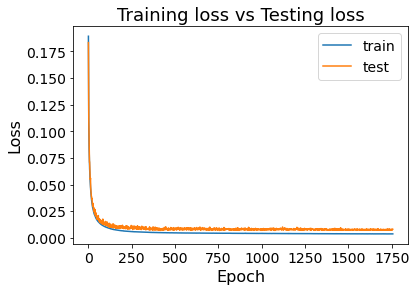

In [31]:
lr = 0.00001
EPOCHS = 6000

# initial_learning_rate * decay_rate ^ (step / decay_steps)
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=5e-4, 
                                                          decay_steps=10000,
                                                          decay_rate=0.99)

model_rnn.compile(
              optimizer=Adam(learning_rate=lr_schedule), 
#               optimizer='adam',
              loss='mse',
              metrics=['mae'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=1000)
mc = ModelCheckpoint('saved_model/rnn_shift_anyday_24h_4layer_no_sc.h5', monitor='val_mae', mode='min', verbose=2, save_best_only=True)


history = model_rnn.fit(train_X, train_y,
                    batch_size=512,
                    epochs=EPOCHS,
                    validation_data=(test_X, test_y),
                    verbose=2,
                    shuffle=True,
                       callbacks=[es, mc])

plt.rcParams["figure.figsize"] = (8, 6)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=14)
plt.title("Training loss vs Testing loss", fontsize=18)
# plt.savefig('graph/rnn_loss.png', dpi=300)
plt.show()

### Performance

In [32]:
from tensorflow.keras.models import load_model
saved_model = load_model('saved_model/rnn_shift_anyday_24h_4layer_no_sc.h5')

In [33]:
yhat = saved_model.predict(test_X)
inv_yhat = scaler.inverse_transform(yhat)
inv_y = scaler.inverse_transform(test_y)

inv_yhat = pd.DataFrame(inv_yhat)
inv_y = pd.DataFrame(inv_y)
print("inv_y.shape, inv_yhat.shape", inv_y.shape, inv_yhat.shape)

error = inv_yhat - inv_y
print(error.shape)

inv_y.shape, inv_yhat.shape (6994, 24) (6994, 24)
(6994, 24)


In [34]:
print('MAE = {}'.format(float("{:.3f}".format(mae(inv_yhat.iloc[:, :], inv_y.iloc[:, :])))))
print('RMSE = {}'.format(float("{:.3f}".format(sqrt(mse(inv_yhat.iloc[:, :], inv_y.iloc[:, :]))))))

MAE = 3.975
RMSE = 5.232
